# Importing libraries

In [76]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRFClassifier
import matplotlib.pyplot as plt
import sklearn as skl

In [73]:
#import sys
#!{sys.executable} -m pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 9.1 MB/s eta 0:00:000m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 10.4 MB/s eta 0:00:00


# Reading the data

In [2]:
#read data and shuffle
bhbh = pd.read_csv('../Data/BHBH.csv')
bhbh = bhbh.sample(frac=1, random_state=4269)

#adding q column
bhbh['q'] = np.where(bhbh['Mass_1_out']>bhbh['Mass_0_out'], bhbh['Mass_0_out']/bhbh['Mass_1_out'], bhbh['Mass_1_out']/bhbh['Mass_0_out'] )
bhbh.head()

,Unnamed: 0,name,Mass_0,Z_0,spin_0,SN_0,Tstart_0,Mass_1,Z_1,a,...,Temperature_0,Mass_1_out,Semimajor,Eccentricity,GWtime,BWorldtime,RLO,CE,tdelay,q
60395,209,0_237173268166122,38.986,0.001,0.0,rapid_gauNS,zams,36.603,0.001,36900.0,...,1456.304,35.000250,38613.90000,0.469578,1.467217e+15,5.305830,NaN,NaN,1.467217e+15,0.945802
74427,314,0_619601822689455,53.812,0.010,0.0,rapid_gauNS,zams,45.722,0.010,1840.0,...,2113.531,14.892850,650.26520,0.015402,3.159041e+09,4.467546,2.0,NaN,3.159041e+09,0.847657
19596,182,0_627668720580822,62.816,0.001,0.0,rapid_gauNS,zams,44.208,0.001,9070.0,...,1184.211,41.659050,9848.93600,0.085256,6.046951e+12,4.666363,NaN,NaN,6.046951e+12,0.744376
78838,298,0_956602933765968,32.894,0.010,0.0,rapid_gauNS,zams,24.726,0.010,94.4,...,3023.349,5.982366,67.27397,0.209334,3.494275e+06,6.771645,3.0,NaN,3.494282e+06,0.696746
74567,110,0_435695643683693,76.275,0.001,0.0,rapid_gauNS,zams,60.763,0.001,1090.0,...,1474.168,35.156080,590.51490,0.025411,2.013698e+08,3.814600,2.0,NaN,2.013698e+08,0.973463


## Setting the labels

In [3]:
#number of bins
n_bins=200

#histogram and cut to assign the labels
count, bin_edg = np.histogram(bhbh['q'], bins= n_bins, range=(0,1))
bhbh['label'] = pd.cut(bhbh['q'], bins=bin_edg, labels=False)

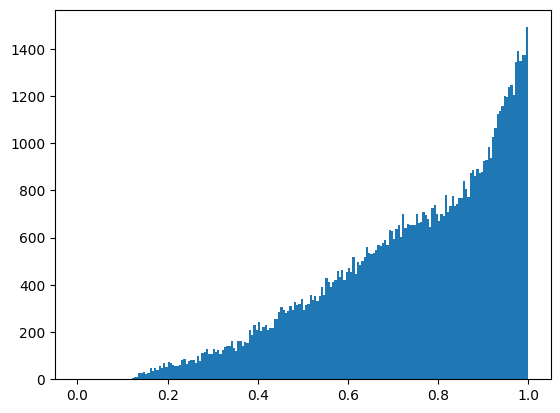

In [4]:
#histogram of the q
center = (bin_edg[1:]+bin_edg[:-1])/2
plt.bar(center, count, width=np.diff(bin_edg));

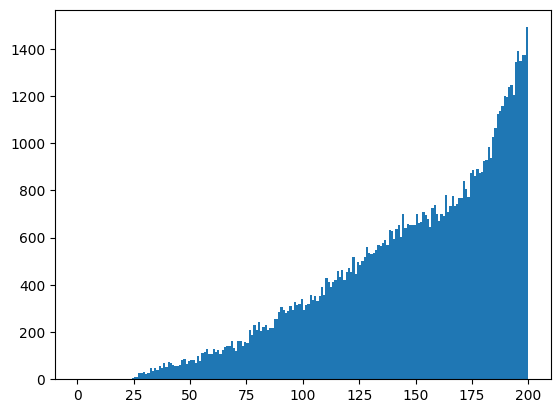

In [5]:
#histogram of labels
plt.hist(bhbh['label'], range=(0, n_bins), bins=n_bins, );

## Another way to set the labels with histogram (deprecated)

In [6]:
#lower=0
#upper=1
# n_bins=244
#bin_labels=np.linspace(lower,upper,num=n_bins+1) # I need one bin more because otherwise 
                                                 # I wouldn't get exactly n_bins labels at the end
#bhbh['q_labels_hist']=pd.cut(bhbh['q'], n_bins+1, labels=bin_labels)

## Another way to set the label (deprecated)

In [7]:
# Setting the label

#bhbh['q_label'] = (bhbh['q']*n_bins).astype('int')
#bhbh['q_label']=(bhbh['q'].round(2)*100).astype('int')


## Preparing the data for xgboost

In [8]:
#division between train and test set
r_train = 0.75
r_test = 1 - r_train

m_train = int(r_train*bhbh.shape[0])
m_test = bhbh.shape[0]-m_train

In [9]:
#train
feature = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][:m_train]
label = bhbh[['label']][:m_train]
train = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e', 'label']][:m_train]
dtrain = xgb.DMatrix(feature, label=label)

In [11]:
#test
feature = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][m_train:]
label = bhbh[['label']][m_train:]
test = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e', 'label']][m_train:]
dtest = xgb.DMatrix(feature, label=label)

## Implementation of RF classifier with XGBoost

In [67]:
#parameters
n_estimators = 10
max_depth = 6
learning_rate = 0.3
grow_policy = 0
max_leaves = n_bins

param = {'n_estimators' : 10, 
        'max_depth' : 6,
        'learning_rate' : 0.3,
        'grow_policy' : 0,
        'max_leaves' : n_bins
        }

In [77]:
RF = XGBRFClassifier(param)

ImportError: sklearn needs to be installed in order to use this module

## Boost Parameters

In [12]:
param = {'max_depth': 6, 'eta': 0.3, 'objective': 'multi:softprob'}
#param['nthread'] = 4
param['eval_metric'] = 'auc'
param['num_class']=n_bins
#param['eval_metric'] = ['auc', 'ams@0']

evallist = [(dtrain, 'train'), (dtest, 'eval')]

## Training

In [13]:
param

{'max_depth': 6,
 'eta': 0.3,
 'objective': 'multi:softprob',
 'eval_metric': 'auc',
 'num_class': 200}

In [14]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

/home/zenn/anaconda3/envs/dask/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[11:42:54] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:42:55] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[0]	train-auc:nan	eval-auc:nan
[11:43:08] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:43:09] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[1]	train-auc:nan	eval-auc:nan
[11:43:23] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:43:23] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[2]	train-auc:nan	eval-auc:nan
[11:43:36] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[11:43:37] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[3]	train-auc:nan	e

## Saving the model

In [15]:
bst.save_model('0001.model')

## Loading a saved model

In [16]:
#bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('0001.model')  # load data

## Predictions of the model

In [17]:
ypred = bst.predict(dtest)

In [18]:
#bst.score(data, label)

In [19]:
prediction = pd.DataFrame(ypred)
a=np.array(prediction)
a.shape

(20474, 200)

In [20]:
prediction.loc[:,[0,3,4]]

,0,3,4
0,0.001031,0.001031,0.001031
1,0.001186,0.001186,0.001186
2,0.001105,0.001105,0.001105
3,0.001101,0.001101,0.001101
4,0.000982,0.000982,0.000982
...,...,...,...
20469,0.001083,0.001083,0.001083
20470,0.001195,0.001195,0.001195
20471,0.001143,0.001143,0.001143
20472,0.000731,0.000731,0.000731


In [46]:
example = np.array(prediction)[3,:]
example

array([0.00110073, 0.00110073, 0.00110073, 0.00110073, 0.00110073,
       0.00110073, 0.00110073, 0.00110073, 0.00110073, 0.00110073,
       0.00110073, 0.00110073, 0.00110073, 0.00111297, 0.00110073,
       0.00110073, 0.00110073, 0.00110073, 0.00110073, 0.00110073,
       0.00112523, 0.0011067 , 0.0011375 , 0.00111297, 0.00112523,
       0.00112239, 0.00112729, 0.00110742, 0.00110366, 0.00111364,
       0.00110356, 0.00111623, 0.00110639, 0.00110643, 0.00110512,
       0.00113681, 0.00111483, 0.00110419, 0.00110894, 0.00110418,
       0.00111555, 0.00111047, 0.00111827, 0.00111741, 0.00112467,
       0.00114652, 0.0011189 , 0.00113911, 0.00111374, 0.0011194 ,
       0.00112511, 0.00112756, 0.0011185 , 0.00134918, 0.001124  ,
       0.0011065 , 0.00115306, 0.00115647, 0.00116896, 0.0014389 ,
       0.00112679, 0.00112676, 0.00124525, 0.00151895, 0.001234  ,
       0.00115636, 0.00145886, 0.00169908, 0.00129752, 0.00114241,
       0.00119504, 0.0016276 , 0.00130931, 0.00120373, 0.00121

In [47]:
example.mean()

0.005

In [48]:
x = np.arange(0, n_bins)
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [49]:
(x*example).sum()

145.31650684890337

In [50]:
example.std()

0.005193011

In [51]:
np.sqrt((x**2*example).sum()-(x*example).sum()**2)

43.99047008639411

In [52]:
np.array(test)[3,:]

array([3.3701e+01, 1.0000e-02, 2.9312e+01, 1.0000e-02, 3.8200e+02,
       7.6400e-02, 1.5600e+02])

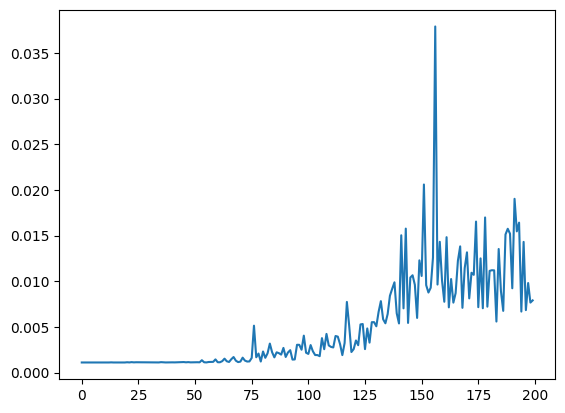

In [53]:
x = np.arange(0, n_bins)
plt.plot(x, example)

In [41]:
bhbh['q_label'][60001]

KeyError: 'q_label'

In [42]:
prediction_tot = np.argmax(a, axis=1)
prediction_tot.shape

(20474,)

ValueError: x and y must be the same size

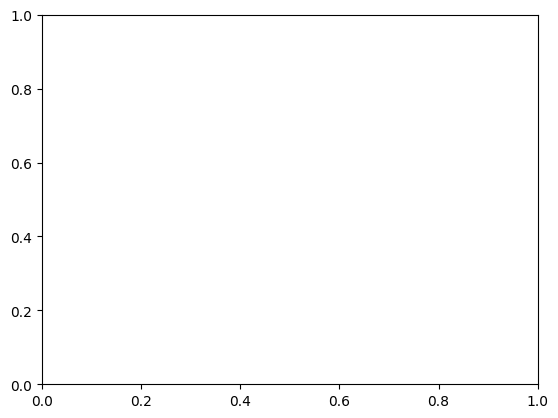

In [43]:
plt.scatter( prediction_tot, bhbh['q'][60000:70000], s=0.5, alpha=0.5)

In [29]:
plt.hist(prediction_tot);
plt.hist(bhbh['q_label'][60000:70000], alpha=0.5);

NameError: name 'prediction_tot' is not defined

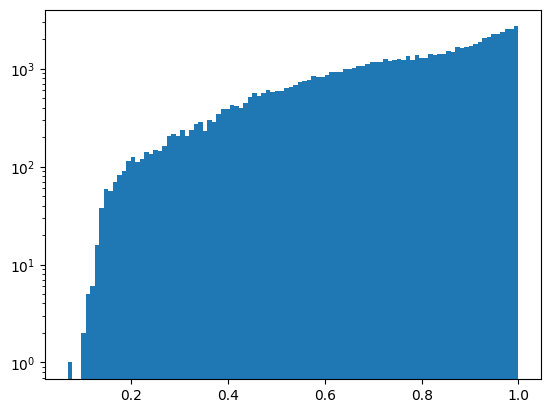

In [30]:
plt.hist(bhbh['q'], bins=100, log=True);